In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

Датасет лежит по ссылке: https://drive.google.com/file/d/1Czza-jFBGaJyBm0nypvAOdWLljEC89d-/view?usp=sharing

In [ ]:
df.head()

,datemin,visits,accounts,applications,games
0,2022-09-01,763,175,40,29
1,2022-10-01,848,222,68,59
2,2022-11-01,793,207,66,54
3,2022-12-01,815,206,65,45
4,2023-01-01,868,229,77,24


In [ ]:
import psycopg2
from plotly import graph_objects as go

conn = psycopg2.connect(database="postgres", user="student", password="JvLda93aA", host="158.160.52.106", port="5432")
cur = conn.cursor()

# запрос
cur.execute("WITH monthboundaries(min, max) AS (\
VALUES\
(DATE '2022-09-01', DATE '2022-10-01'),\
    (DATE '2022-10-01', DATE '2022-11-01'),\
    (DATE '2022-11-01', DATE '2022-12-01'),\
    (DATE '2022-12-01', DATE '2023-01-01'),\
    (DATE '2023-01-01', DATE '2023-02-01')\
)\
SELECT \
mb.min AS datemin,\
SUM(CASE WHEN clnt.client_rk IS NOT NULL THEN 1 ELSE 0 END) AS visits,\
SUM(CASE WHEN acnt.account_rk IS NOT NULL THEN 1 ELSE 0 END) AS accounts,\
SUM(CASE WHEN aplt.application_rk IS NOT NULL THEN 1 ELSE 0 END) AS applications,\
SUM(CASE WHEN gm.game_rk IS NOT NULL THEN 1 ELSE 0 END) AS games \
FROM \
monthboundaries mb \
LEFT JOIN \
msu_analytics.client clnt \
ON \
clnt.Visit_dttm >= mb.min AND clnt.Visit_dttm < mb.max \
LEFT JOIN \
msu_analytics.account acnt \
ON \
clnt.client_rk = acnt.client_rk AND (acnt.Registration_dttm IS NULL OR acnt.Registration_dttm >= mb.min AND acnt.Registration_dttm < mb.max) \
LEFT JOIN \
msu_analytics.application aplt \
ON \
acnt.account_rk = aplt.account_rk AND (aplt.Application_dttm IS NULL OR aplt.Application_dttm >= mb.min AND aplt.Application_dttm < mb.max) \
LEFT JOIN \
msu_analytics.game gm \
ON \
gm.game_rk = aplt.game_rk and gm.game_flg = 1 \
GROUP BY \
mb.min \
ORDER BY \
mb.min")
result = cur.fetchall()

fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'сентябрь 2022',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[0][1], result[0][2], result[0][3], result[0][4]],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'октябрь 2022',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[1][1], result[1][2], result[1][3], result[1][4]],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'ноябрь 2022',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[2][1], result[2][2], result[2][3], result[2][4]],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'декабрь 2022',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[3][1], result[3][2], result[3][3], result[3][4]],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'январь 2023',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[4][1], result[4][2], result[4][3], result[4][4]],
    textinfo = "value+percent initial"))

fig.update_layout(width=1500, height=600)
fig.show()

Получившаяся воронка (изображение сохранила отдельно, т.к. визуализация может не отобразиться при выгрузке ipynb):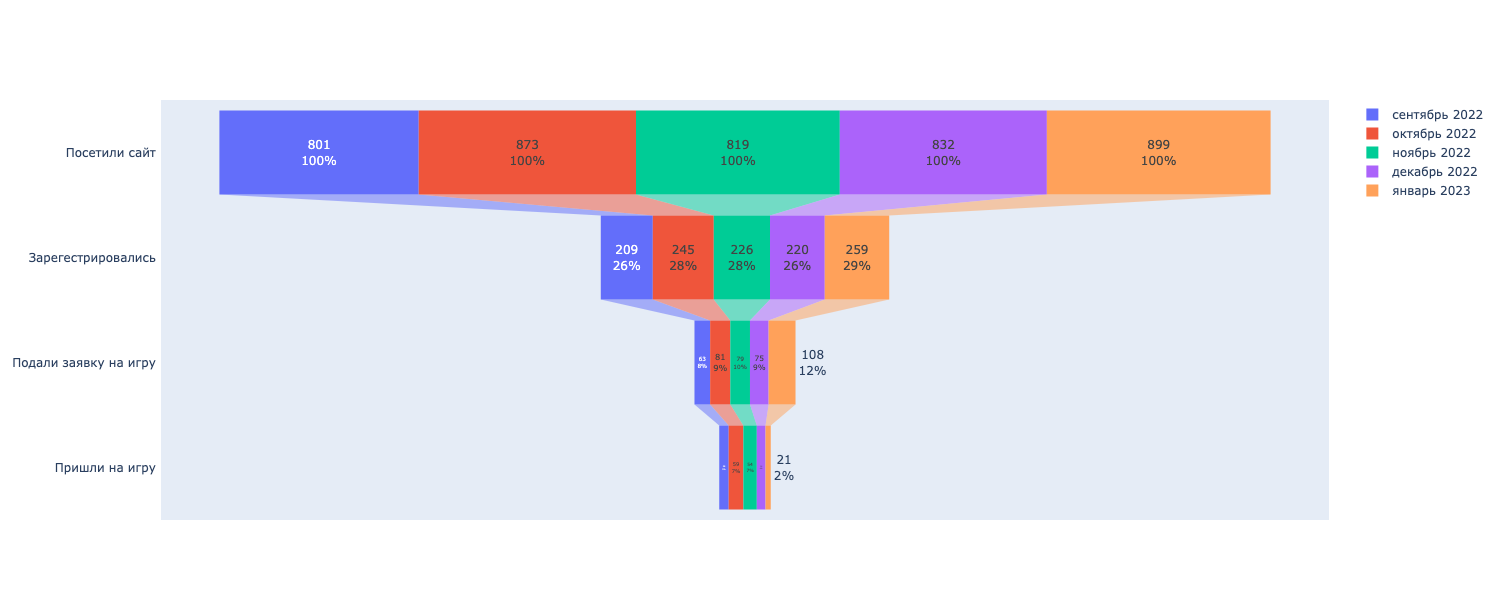

Для анализа необходимо вычислить коэффициенты конверсии между каждым уровнем. Среднее значение коэффициентов конверсий по всем 5 месяцам следующее:
* **С посещения сайта:**
    - на регистрацию: 27%
    - на подачу заявки: 10%
    - на участие в игре: 5%

* **С регистрации:**
    - на подачу заявки: 35%

* **С подачи заявки:**
    - на участие в игре: 53%

Большая часть пользователей, посетивших сайт не зарегестрировались на нем. Это может происходить по нескольким причинам:
- Затруднительный поиск нужной информации на страницах, неудобная навигация на сайте
- Сложности при заполнении формы регистрации (заполнение занимает много времени, форма не оптимизирована для мобильных устрйств)

Аналогично, среди зарегестрировавшихся пользователей не многие подали заявку на игру. Причины могут быть те же. Чтобы увеличить количество отправленных заявок, необходимо сделать форму интуитивно понятной для пользователей, регулярно тестировать ее на работоспособность.

Достаточно большой процент людей, подавших заявку на игру, принимают в ней участие (около 53%), но среди тех, кто посетил сайт, только 8 процентов зарегестрировались на игру и 5 процентов тех же людей ее посетили. Такая статистика может быть связана с впечатлением об игре, которое получено у пользователей, посетивших сайт: недостаточно информации об играх. Возможные улучшения сайта:
- добавить больше фото, описания, отзывов
- улучшить пользовательский интерфейс

Также важно улучшать организацию игр и игровой процесс, основываясь на отзывах пользователей, а также обращать внимание на все замечания по поводу прошедших игр.

Проанализируем те же данные по неделям (первая неделя каждого из 5 месяцев - для упрощения восприятия)

In [ ]:
import psycopg2
from plotly import graph_objects as go

conn = psycopg2.connect(database="postgres", user="student", password="JvLda93aA", host="158.160.52.106", port="5432")
cur = conn.cursor()

# запрос
cur.execute("WITH monthboundaries(min, max) AS (\
VALUES\
(DATE '2022-09-05', DATE '2022-09-12'),\
(DATE '2022-10-03', DATE '2022-10-10'),\
(DATE '2022-11-07', DATE '2022-11-14'),\
(DATE '2022-12-05', DATE '2022-12-12'),\
(DATE '2023-01-02', DATE '2023-01-09')\
)\
SELECT \
mb.min AS datemin,\
SUM(CASE WHEN clnt.client_rk IS NOT NULL THEN 1 ELSE 0 END) AS visits,\
SUM(CASE WHEN acnt.account_rk IS NOT NULL THEN 1 ELSE 0 END) AS accounts,\
SUM(CASE WHEN aplt.application_rk IS NOT NULL THEN 1 ELSE 0 END) AS applications,\
SUM(CASE WHEN gm.game_rk IS NOT NULL THEN 1 ELSE 0 END) AS games \
FROM \
monthboundaries mb \
LEFT JOIN \
msu_analytics.client clnt \
ON \
clnt.Visit_dttm >= mb.min AND clnt.Visit_dttm < mb.max \
LEFT JOIN \
msu_analytics.account acnt \
ON \
clnt.client_rk = acnt.client_rk AND (acnt.Registration_dttm IS NULL OR acnt.Registration_dttm >= mb.min AND acnt.Registration_dttm < mb.max) \
LEFT JOIN \
msu_analytics.application aplt \
ON \
acnt.account_rk = aplt.account_rk AND (aplt.Application_dttm IS NULL OR aplt.Application_dttm >= mb.min AND aplt.Application_dttm < mb.max) \
LEFT JOIN \
msu_analytics.game gm \
ON \
gm.game_rk = aplt.game_rk and gm.game_flg = 1 \
GROUP BY \
mb.min \
ORDER BY \
mb.min")
result = cur.fetchall()

fig = go.Figure()
fig.add_trace(go.Funnel(
    name = '05.09-11.09',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[0][1], result[0][2], result[0][3], result[0][4]],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '03.10-09.10',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[1][1], result[1][2], result[1][3], result[1][4]],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '07.11-12.11',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[2][1], result[2][2], result[2][3], result[2][4]],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '05.12-11.12',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[3][1], result[3][2], result[3][3], result[3][4]],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '02.01-08.01',
    y = ["Посетили сайт ", "Зарегестрировались ", "Подали заявку на игру ", "Пришли на игру "],
    x = [result[4][1], result[4][2], result[4][3], result[4][4]],
    textinfo = "value+percent initial"))

fig.update_layout(width=2000, height=600)
fig.show()

Получившаяся воронка (изображение сохранила отдельно, т.к. визуализация может не отобразиться при выгрузке ipynb):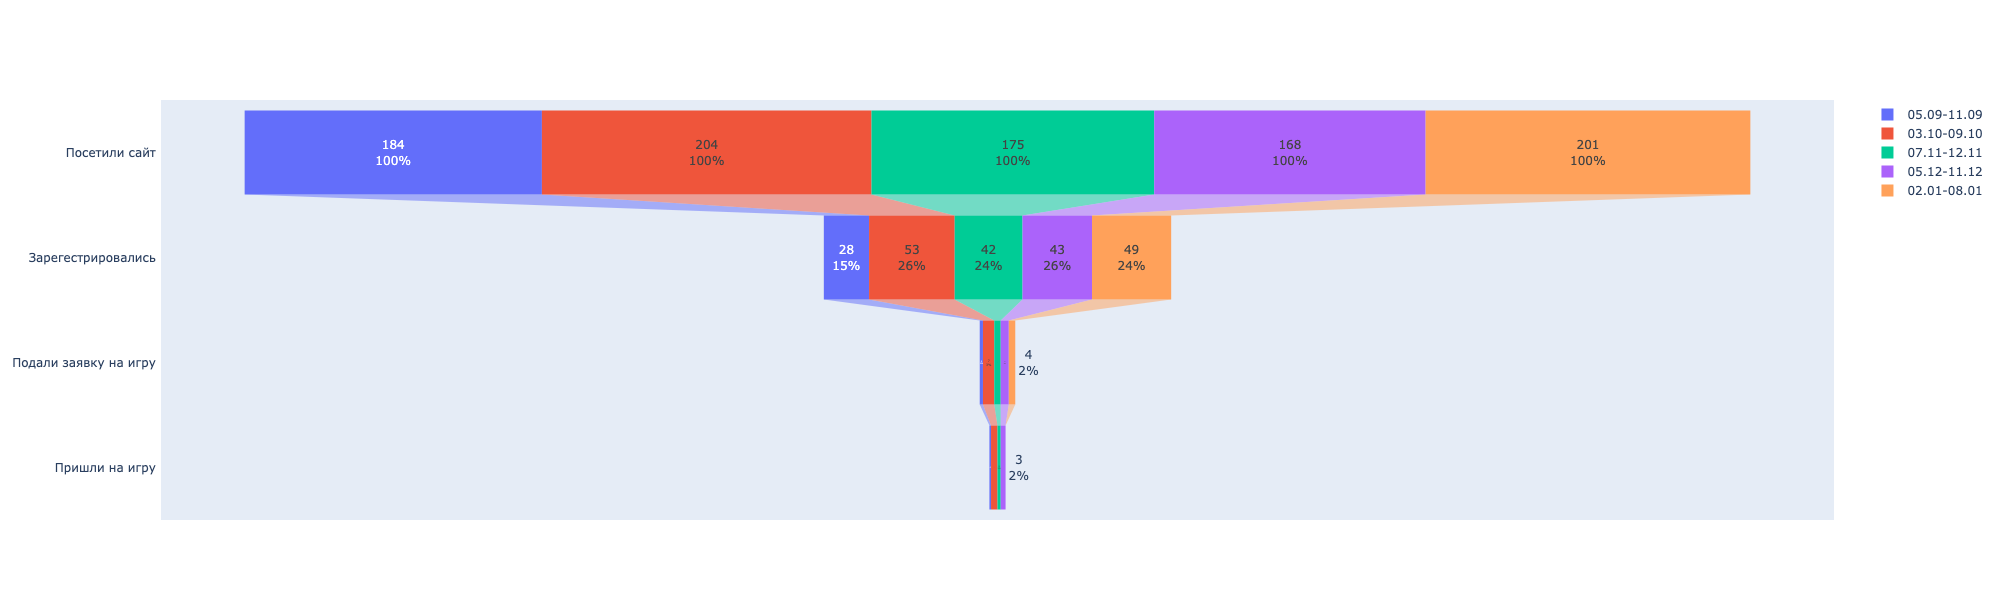

Среднее значение коэффициентов конверсий по неделям каждого следующее:
* **С посещения сайта:**
    - на регистрацию: 23%
    - на подачу заявки: 2%
    - на участие в игре: 2%

* **С регистрации:**
    - на подачу заявки: 7%

* **С подачи заявки:**
    - на участие в игре: 53%

Наблюдаем аналогичную месяцам динамику. В течение недели около 27% посетивших сайт людей зарегестрировались на нем, среди зарегестрировавшихся в ту же неделю около 9% подали заявку на игру. Для улучшения динамики подойдут методы, описанные в предыдущем пункте.